In [1]:
from __future__ import print_function
import argparse
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
def seed_it(seed):
    random.seed(seed) #可以注释掉
    os.environ["PYTHONSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) #这个懂吧
    torch.backends.cudnn.deterministic = True #确定性固定
    torch.backends.cudnn.benchmark = True #False会确定性地选择算法，会降低性能
    torch.backends.cudnn.enabled = True  #增加运行效率，默认就是True
    torch.manual_seed(seed)
seed_it(1314)

In [3]:
class Generator(nn.Module):
    def __init__(self, nc=10, nz=100, n_out=1, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz+nc, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, n_out, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [4]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc+1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [5]:
dataset = dset.MNIST(root='./data', download=True,
                     transform=transforms.Compose([
                         #transforms.Resize(imageSize),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5,), (0.5,)),
                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nc = 1
nz = 100
ngf = 8
ndf = 16

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
netG = Generator(ngf=ngf).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(110, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(8, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)


In [8]:
netD = Discriminator(ndf=ndf).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(2, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [9]:
teacher_G = Generator(ngf=64).to(device)
teacher_G.load_state_dict(torch.load('./checkpoint_cgan/netG_epoch_24.pth'))

<All keys matched successfully>

In [10]:
fixed_input = torch.load('./fixed_input.pth')

In [11]:
fixed_input.shape

torch.Size([80, 110, 1, 1])

In [12]:
outf = './checkpoint_cgan_distill_8_16'
os.mkdir(outf)

GAN_criterion = nn.BCELoss()
L1_criterion = nn.L1Loss()

real_label = 1.
fake_label = 0.

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))


img_list = []
G_losses = []
D_losses = []
G_gan_losses = []



for epoch in range(25):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        
        images, real_conditions = data
        
        real_cpu = images.to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        real_d_conditions = torch.unsqueeze(real_conditions,1)
        real_d_conditions = torch.unsqueeze(real_d_conditions,2)
        real_d_conditions = torch.unsqueeze(real_d_conditions,3)
        real_d_conditions = real_d_conditions.expand(-1,-1,28,28)
        real_d_conditions = real_d_conditions.to(device)
        
        real_d_input = torch.cat([real_cpu, real_d_conditions], 1)

        output = netD(real_d_input).view(-1)
        errD_real = GAN_criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        
        fake_conditions = torch.randint(0, 10, (batch_size,)).to(device)
        
        fake_g_conditions = torch.unsqueeze(fake_conditions,1).expand(batch_size,10)
        fake_g_conditions = torch.unsqueeze(fake_g_conditions,2)
        fake_g_conditions = torch.unsqueeze(fake_g_conditions,3)
        fake_g_conditions = fake_g_conditions.to(device)
        fake_g_input = torch.cat([noise, fake_g_conditions], 1)
        
        fake = netG(fake_g_input)
        label.fill_(fake_label)
        
        fake_d_conditions = torch.unsqueeze(fake_conditions,1)
        fake_d_conditions = torch.unsqueeze(fake_d_conditions,2)
        fake_d_conditions = torch.unsqueeze(fake_d_conditions,3)
        fake_d_conditions = fake_d_conditions.expand(-1,-1,28,28)
        fake_d_conditions = fake_d_conditions.to(device)
        
        fake_d_input = torch.cat([fake, fake_d_conditions], 1)
        
        output = netD(fake_d_input.detach()).view(-1)
        errD_fake = GAN_criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        output = netD(fake_d_input).view(-1)
        
        fake_teacher = teacher_G(fake_g_input)
        
        
        errG_gan = GAN_criterion(output, label)
        errG_reconst = L1_criterion(fake_teacher, fake)
        errG = errG_gan + errG_reconst
        
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()


        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\nLoss_G_gan: %.4f\tLoss_G_reconst: %.4f\n D(x): %.4f\tD(G(z)): %.4f / %.4f\n'
                  % (epoch, 25, i, len(dataloader),
                     errD.item(), errG.item(), 
                     errG_gan.item(), errG_reconst.item(), 
                     D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())
        G_gan_losses.append(errG_gan.item())

    with torch.no_grad():
        fake = netG(fixed_input).detach().cpu()
    vutils.save_image(fake.detach(),
                      '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                      normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/25][0/469]	Loss_D: 1.4649	Loss_G: 1.7064
Loss_G_gan: 0.7386	Loss_G_reconst: 0.9678
 D(x): 0.5593	D(G(z)): 0.5701 / 0.4780

[0/25][100/469]	Loss_D: 0.0160	Loss_G: 5.9493
Loss_G_gan: 4.9842	Loss_G_reconst: 0.9651
 D(x): 0.9919	D(G(z)): 0.0079 / 0.0076

[0/25][200/469]	Loss_D: 0.0072	Loss_G: 6.6454
Loss_G_gan: 5.6746	Loss_G_reconst: 0.9708
 D(x): 0.9972	D(G(z)): 0.0044 / 0.0041

[0/25][300/469]	Loss_D: 0.0037	Loss_G: 7.7066
Loss_G_gan: 6.7475	Loss_G_reconst: 0.9591
 D(x): 0.9977	D(G(z)): 0.0014 / 0.0014

[0/25][400/469]	Loss_D: 0.0029	Loss_G: 7.5353
Loss_G_gan: 6.5989	Loss_G_reconst: 0.9364
 D(x): 0.9987	D(G(z)): 0.0016 / 0.0016

[1/25][0/469]	Loss_D: 0.0015	Loss_G: 8.3610
Loss_G_gan: 7.4508	Loss_G_reconst: 0.9102
 D(x): 0.9991	D(G(z)): 0.0006 / 0.0006

[1/25][100/469]	Loss_D: 0.0012	Loss_G: 8.3136
Loss_G_gan: 7.4277	Loss_G_reconst: 0.8859
 D(x): 0.9994	D(G(z)): 0.0006 / 0.0006

[1/25][200/469]	Loss_D: 0.0374	Loss_G: 4.7866
Loss_G_gan: 3.9732	Loss_G_reconst: 0.8133
 D(x): 0.9896	D(G(z)

[13/25][0/469]	Loss_D: 1.3444	Loss_G: 1.8173
Loss_G_gan: 1.4982	Loss_G_reconst: 0.3191
 D(x): 0.9100	D(G(z)): 0.6882 / 0.2533

[13/25][100/469]	Loss_D: 1.1694	Loss_G: 1.8502
Loss_G_gan: 1.5423	Loss_G_reconst: 0.3079
 D(x): 0.7516	D(G(z)): 0.5443 / 0.2455

[13/25][200/469]	Loss_D: 0.7150	Loss_G: 1.8179
Loss_G_gan: 1.5089	Loss_G_reconst: 0.3089
 D(x): 0.7716	D(G(z)): 0.3335 / 0.2445

[13/25][300/469]	Loss_D: 0.7128	Loss_G: 1.6703
Loss_G_gan: 1.3895	Loss_G_reconst: 0.2808
 D(x): 0.6397	D(G(z)): 0.1737 / 0.2682

[13/25][400/469]	Loss_D: 0.8404	Loss_G: 2.1575
Loss_G_gan: 1.8613	Loss_G_reconst: 0.2962
 D(x): 0.8078	D(G(z)): 0.4430 / 0.1731

[14/25][0/469]	Loss_D: 0.6050	Loss_G: 2.1330
Loss_G_gan: 1.8206	Loss_G_reconst: 0.3124
 D(x): 0.8849	D(G(z)): 0.3591 / 0.1827

[14/25][100/469]	Loss_D: 1.0824	Loss_G: 1.5807
Loss_G_gan: 1.2684	Loss_G_reconst: 0.3123
 D(x): 0.7486	D(G(z)): 0.5109 / 0.3013

[14/25][200/469]	Loss_D: 0.8293	Loss_G: 2.0548
Loss_G_gan: 1.7396	Loss_G_reconst: 0.3152
 D(x): 0.759

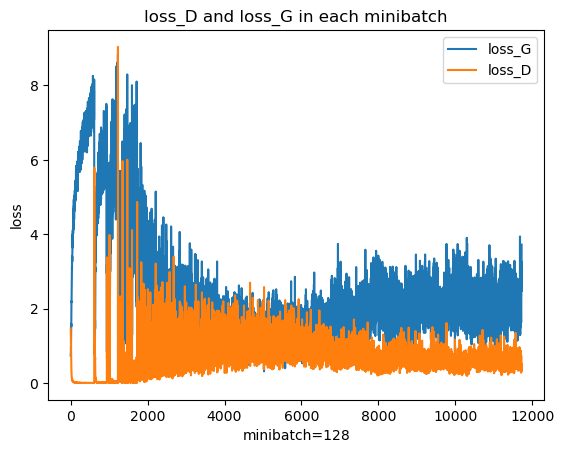

In [13]:
x_lim = range(len(G_losses))
plt.plot(x_lim, G_gan_losses, label='loss_G')
plt.plot(x_lim, D_losses, label='loss_D')
plt.xlabel('minibatch=128')
plt.ylabel('loss')
plt.title('loss_D and loss_G in each minibatch')
plt.legend()
plt.show()

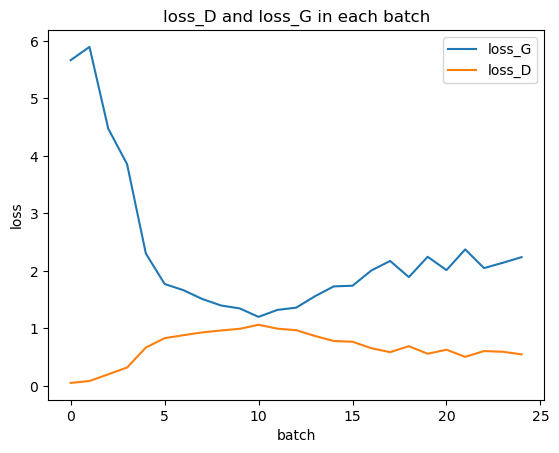

In [14]:
G_batch_loss = []
D_batch_loss = []
g_loss = 0
d_loss = 0
batch = 469
for i in range(25):
    for j in range(469):
        g_loss = g_loss + G_gan_losses[i*batch+j]
        d_loss = d_loss + D_losses[i*batch+j]
    g_loss = g_loss/469
    d_loss = d_loss/469
    
    G_batch_loss.append(g_loss)
    D_batch_loss.append(d_loss)
    
    g_loss = 0
    d_loss = 0
    
x_lim = range(25)
plt.plot(x_lim, G_batch_loss,label='loss_G')
plt.plot(x_lim, D_batch_loss,label='loss_D')
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('loss_D and loss_G in each batch')
plt.legend()
plt.show()